# Optimization of a Dissipative Quantum Gate

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import copy
from functools import partial
from itertools import product
%watermark -v --iversions

matplotlib.pylab 1.15.4
scipy            1.2.1
krotov           0.3.0
qutip            4.3.1
matplotlib       3.0.3
numpy            1.15.4
CPython 3.6.8
IPython 7.3.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{int}[0]{\text{int}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{ketbra}[2]{\vert#1\rangle\!\langle#2\vert}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This example illustrates the optimization for a quantum gate in an open quantum system, where the dynamics is governed by the Liouville-von Neumann equation. A naive extension of a gate optimization to Liouville space would seem to imply that it is necessary to optimize over the full basis of Liouville space (16 matrices, for a two-qubit gate). However, [Goerz et al., New J. Phys. 16, 055012 (2014)][1] showed that is not necessary, but that a set of 3 density matrices is sufficient to track the optimization.

This example reproduces the "Example II" from that paper, considering the optimization towards a $\sqrt{\text{iSWAP}}$ two-qubit gate on a system of two transmons with a shared transmission line resonator.

[1]: https://michaelgoerz.net/research/Goerz_NJP2014.pdf

## The two-transmon system

We consider the Hamiltonian from Eq (17) in the paper, in the rotating wave approximation, together with spontaneous decay and dephasing of each qubit. Alltogether, we define the Liouvillian as follows:

In [2]:
def two_qubit_transmon_liouvillian(
    ω1, ω2, ωd, δ1, δ2, J, q1T1, q2T1, q1T2, q2T2, T, Omega, n_qubit
):
    from qutip import tensor, identity, destroy

    b1 = tensor(identity(n_qubit), destroy(n_qubit))
    b2 = tensor(destroy(n_qubit), identity(n_qubit))

    H0 = (
        (ω1 - ωd - δ1 / 2) * b1.dag() * b1
        + (δ1 / 2) * b1.dag() * b1 * b1.dag() * b1
        + (ω2 - ωd - δ2 / 2) * b2.dag() * b2
        + (δ2 / 2) * b2.dag() * b2 * b2.dag() * b2
        + J * (b1.dag() * b2 + b1 * b2.dag())
    )

    H1_re = 0.5 * (b1 + b1.dag() + b2 + b2.dag())  # 0.5 is due to RWA
    H1_im = 0.5j * (b1.dag() - b1 + b2.dag() - b2)

    H = [H0, [H1_re, Omega], [H1_im, ZeroPulse]]

    A1 = np.sqrt(1 / q1T1) * b1  # decay of qubit 1
    A2 = np.sqrt(1 / q2T1) * b2  # decay of qubit 2
    A3 = np.sqrt(1 / q1T2) * b1.dag() * b1  # dephasing of qubit 1
    A4 = np.sqrt(1 / q2T2) * b2.dag() * b2  # dephasing of qubit 2

    L = krotov.objectives.liouvillian(H, c_ops=[A1, A2, A3, A4])
    return L

We will use internal units GHz and ns. Values in GHz contain an implicit factor 2π, and MHz and μs are converted to GHz and ns, respectively:

In [3]:
GHz = 2 * np.pi
MHz = 1e-3 * GHz
ns = 1
μs = 1000 * ns

This implicit factor $2 \pi$ is because frequencies ($\nu$) convert to energies as $E = h \nu$, but our propagation routines assume a unit $\hbar = 1$ for energies. Thus, the factor $h / \hbar = 2 \pi$.

We will use the same parameters as those given in Table 2 of the paper:

In [4]:
ω1 = 4.3796 * GHz  # qubit frequency 1
ω2 = 4.6137 * GHz  # qubit frequency 2
ωd = 4.4985 * GHz  # drive frequency
δ1 = -239.3 * MHz  # anharmonicity 1
δ2 = -242.8 * MHz  # anharmonicity 2
J = -2.3 * MHz     # effective qubit-qubit coupling
q1T1 = 38.0 * μs   # decay time for qubit 1
q2T1 = 32.0 * μs   # decay time for qubit 2
q1T2 = 29.5 * μs   # dephasing time for qubit 1
q2T2 = 16.0 * μs   # dephasing time for qubit 2
T = 400 * ns       # gate duration

In [5]:
tlist = np.linspace(0, T, 2000)

While in the original paper, each transmon was cut off at 6 levels, here we truncate at 5 levels. This makes the propagation faster, while potentially introducing a slightly larger truncation error.

In [6]:
n_qubit = 5        # number of transmon levels to consider

In the Liouvillian, note the control being split up into a separate real and imaginary part. As a guess control we use a real-valued constant pulse with an amplitude of 35 MHz, acting over 400 ns, with a switch-on and switch-off in the first 20 ns (see plot below)

In [7]:
def Omega(t, args):
    E0 = 35.0 * MHz
    return E0 * krotov.shapes.flattop(t, 0, T, t_rise=(20 * ns), func='sinsq')

The imaginary part start out as zero:

In [8]:
def ZeroPulse(t, args):
    return 0.0

We can now instantiate the Liouvillian:

In [9]:
L = two_qubit_transmon_liouvillian(
    ω1, ω2, ωd, δ1, δ2, J, q1T1, q2T1, q1T2, q2T2, T, Omega, n_qubit
)

The guess pulse looks as follows:

In [10]:
def plot_pulse(pulse, tlist, xlimit=None):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    ax.plot(tlist, pulse/MHz)
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('pulse amplitude (MHz)')
    if xlimit is not None:
        ax.set_xlim(xlimit)
    plt.show(fig)

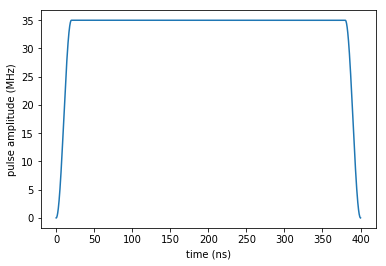

In [11]:
plot_pulse(L[1][1], tlist)

## Optimization objectives

Our target gate is $\Op{O} = \sqrt{\text{iSWAP}}$:

In [12]:
gate = qutip.gates.sqrtiswap()

In [13]:
gate

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  1.        +0.j        ]]

The key idea explored in the paper is that a set of three density matrices is sufficient to track the optimization

\begin{align}
\Op{\rho}_1 &= \sum_{i=1}^{d}
                  \frac{2 (d-i+1)}{d (d+1)} \ketbra{i}{i} \\
              \Op{\rho}_2 &= \sum_{i,j=1}^{d}
                  \frac{1}{d} \ketbra{i}{j} \\
              \Op{\rho}_3 &= \sum_{i=1}^{d}
                  \frac{1}{d} \ketbra{i}{i}
\end{align}

In our case, $d=4$ for a two qubit-gate, and the $\ket{i}$, $\ket{j}$ are the canonical basis states $\ket{00}$, $\ket{01}$, $\ket{10}$, $\ket{11}$

In [14]:
ket00 = qutip.ket((0, 0), dim=(n_qubit, n_qubit))
ket01 = qutip.ket((0, 1), dim=(n_qubit, n_qubit))
ket10 = qutip.ket((1, 0), dim=(n_qubit, n_qubit))
ket11 = qutip.ket((1, 1), dim=(n_qubit, n_qubit))
basis = [ket00, ket01, ket10, ket11]

The three density matrices play different roles in the optimization, and, as shown in the paper, convergence may improve significantly by weighing the states relatively to each other. For this example, we place a strong emphasis on the optimization $\Op{\rho}_1 \rightarrow \Op{O}^\dagger \Op{\rho}_1 \Op{O}$, by a factor of 20. This reflects that the hardest part of the optimization is identifying the basis in which the gate is diagonal. We will be using the real-part functional ($J_{T,\text{re}}$) to evaluate the success of $\Op{\rho}_i \rightarrow \Op{O}\Op{\rho}_i\Op{O}^\dagger$. Because $\Op{\rho}_1$ and $\Op{\rho}_3$ are mixed states, the Hilbert-Schmidt overlap will take values smaller than one in the optimal case. To compensate, we divide the weights by the purity of the respective states.

In [15]:
weights = np.array([20, 1, 1], dtype=np.float64)
weights *= len(weights) / np.sum(weights) # manual normalization
weights /= np.array([0.3, 1.0, 0.25]) # purities

The `krotov.gate_objectives` routine can initialize the density matrices $\Op{\rho}_1$, $\Op{\rho}_2$, $\Op{\rho}_3$ automatically, via the parameter `liouville_states_set`. Alternatively, we could also use the `'full'` basis of 16 matrices or the extended set of $d+1 = 5$ pure-state density matrices.

In [16]:
objectives = krotov.gate_objectives(
    basis,
    gate,
    L,
    liouville_states_set='3states',
    weights=weights,
    normalize_weights=False,
)

The use of `normalize_weights=False` is because we have include the purities in the weights, as discussed above.

## Dynamics under the Guess Pulse

For numerical efficiency, both for the analysis of the guess/optimized controls, we will use a stateful density matrix propagator:

A true physical measure for the success of the optimization is the "average gate fidelity". Evaluating the fidelity requires to simulate the dynamics of the full basis of Liouville space:

In [17]:
full_liouville_basis = [psi * phi.dag() for (psi, phi) in product(basis, basis)]

We propagate these under the guess control:

In [18]:
def propagate_guess(initial_state):
    return objectives[0].propagate(
        tlist,
        propagator=krotov.propagators.DensityMatrixODEPropagator(),
        rho0=initial_state,
    ).states[-1]

In [19]:
full_states_T = qutip.parallel_map(
    propagate_guess, values=full_liouville_basis,
)

In [20]:
print("F_avg = %.3f" % krotov.functionals.F_avg(full_states_T, basis, gate))

F_avg = 0.344


Note that we use $F_{T,\text{re}}$, not $F_{\text{avg}}$ to steer the optimization, as the Krotov boundary condition $\frac{\partial F_{\text{avg}}}{\partial \rho^\dagger}$ would be non-trivial.

Before doing the optimization, we can look the population dynamics under the guess pulse. For this purpose we propagate the pure-state density matrices corresponding to the canonical logical basis in Hilbert space, and obtain the expectation values for the projection onto these same states:

In [21]:
rho00, rho01, rho10, rho11 = [qutip.ket2dm(psi) for psi in basis]

In [22]:
def propagate_guess_for_expvals(initial_state):
    return objectives[0].propagate(
        tlist,
        propagator=krotov.propagators.DensityMatrixODEPropagator(),
        rho0=initial_state,
        e_ops=[rho00, rho01, rho10, rho11]
    )

In [23]:
def plot_population_dynamics(dyn00, dyn01, dyn10, dyn11):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
    axs = np.ndarray.flatten(axs)
    labels = ['00', '01', '10', '11']
    dyns = [dyn00, dyn01, dyn10, dyn11]
    for (ax, dyn, title) in zip(axs, dyns, labels):
        for (i, label) in enumerate(labels):
            ax.plot(dyn.times, dyn.expect[i], label=label)
        ax.legend()
        ax.set_title(title)
    plt.show(fig)

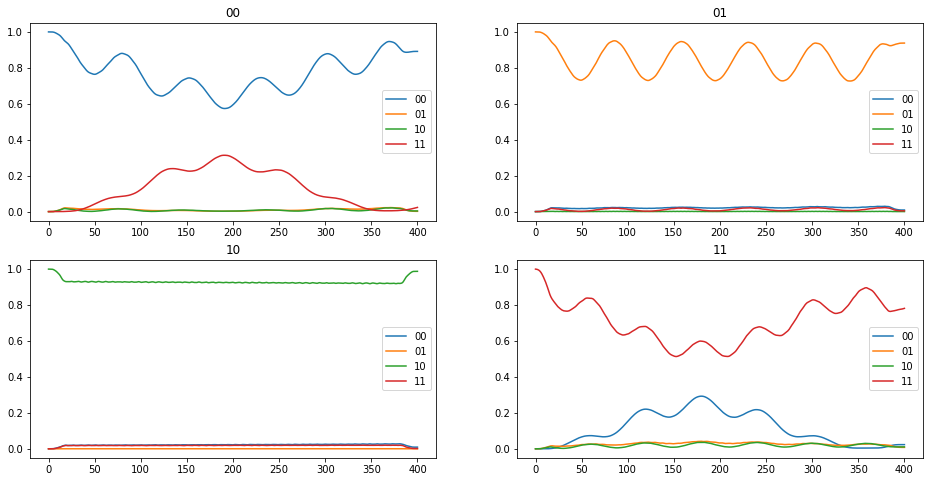

In [24]:
plot_population_dynamics(
    *qutip.parallel_map(
        propagate_guess_for_expvals,
        values=[rho00, rho01, rho10, rho11],
    )
)

## Optimization

We now define the optimization parameters for the controls, the Krotov step size $\lambda_a$ and the update-shape that will ensure that the pulse switch-on and switch-off stays intact.

In [25]:
pulse_options = {
    L[i][1]: dict(
        lambda_a=1.0,
        shape=partial(
            krotov.shapes.flattop, t_start=0, t_stop=T, t_rise=(20 * ns))
        )
    for i in [1, 2]
}

Then we run the optimization for 2000 iterations

In [26]:
oct_result = krotov.optimize_pulses(
    objectives,
    pulse_options,
    tlist,
    propagator=krotov.propagators.DensityMatrixODEPropagator(reentrant=True),
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_re),
    iter_stop=3,
)

  iter.        J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
      0   1.22e-01    0.00e+00   1.22e-01        n/a        n/a     8
      1   7.49e-02    2.26e-02   9.75e-02  -4.67e-02  -2.41e-02    28
      2   7.41e-02    3.98e-04   7.45e-02  -8.12e-04  -4.14e-04    28
      3   7.33e-02    3.70e-04   7.37e-02  -7.55e-04  -3.85e-04    29


(this takes a while)...

In [27]:
dumpfile = "./3states_oct_result.dump"
if os.path.isfile(dumpfile):
    oct_result = krotov.result.Result.load(dumpfile, objectives)
else:
    oct_result = krotov.optimize_pulses(
        objectives,
        pulse_options,
        tlist,
        propagator=krotov.propagators.DensityMatrixODEPropagator(reentrant=True),
        chi_constructor=krotov.functionals.chis_re,
        info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_re),
        iter_stop=5,
        continue_from=oct_result
    )
    oct_result.dump(dumpfile)

In [28]:
oct_result

Krotov Optimization Result
--------------------------
- Started at 2019-02-25 00:43:31
- Number of objectives: 3
- Number of iterations: 2000
- Reason for termination: Reached 2000 iterations
- Ended at 2019-02-25 23:19:34

## Optimization result

In [29]:
optimized_control = oct_result.optimized_controls[0] + 1j * oct_result.optimized_controls[1]

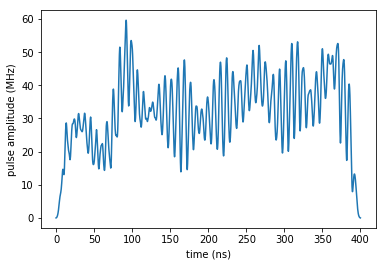

In [30]:
plot_pulse(np.abs(optimized_control), tlist)

In [31]:
def propagate_opt(initial_state):
    return oct_result.optimized_objectives[0].propagate(
        tlist,
        propagator=krotov.propagators.DensityMatrixODEPropagator(),
        rho0=initial_state,
    ).states[-1]

In [32]:
opt_full_states_T = qutip.parallel_map(
    propagate_opt, values=full_liouville_basis,
)

In [33]:
print("F_avg = %.3f" % krotov.functionals.F_avg(opt_full_states_T, basis, gate))

F_avg = 0.977


In [34]:
def propagate_opt_for_expvals(initial_state):
    return oct_result.optimized_objectives[0].propagate(
        tlist,
        propagator=krotov.propagators.DensityMatrixODEPropagator(),
        rho0=initial_state,
        e_ops=[rho00, rho01, rho10, rho11]
    )

Plotting the population dynamics, we see the expected behavior for the $\sqrt{\text{iSWAP}}$ gate.

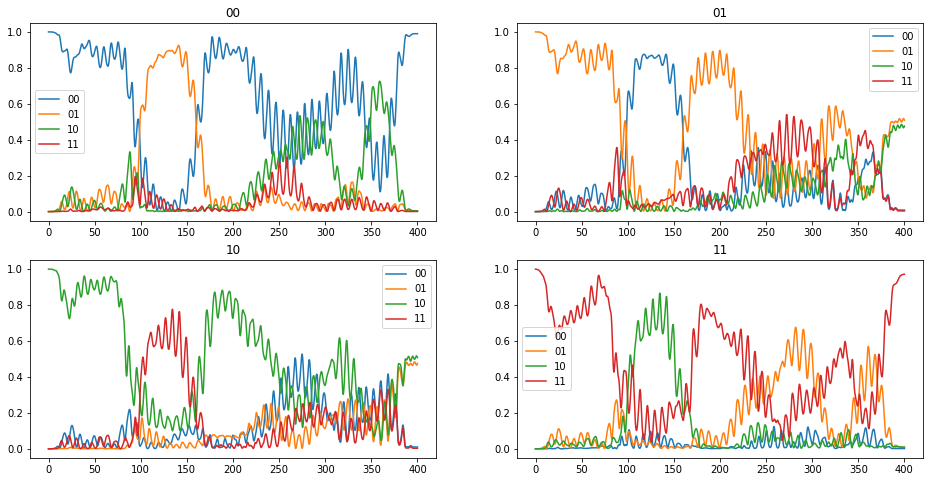

In [35]:
plot_population_dynamics(
    *qutip.parallel_map(
        propagate_opt_for_expvals,
        values=[rho00, rho01, rho10, rho11],
    )
)

In [36]:
def plot_convergence(result):
    fig, ax = plt.subplots()
    ax.semilogy(result.iters, result.info_vals)
    ax.set_xlabel('OCT iteration')
    ax.set_ylabel(r'optimization error $J_{T, re}$')
    plt.show(fig)

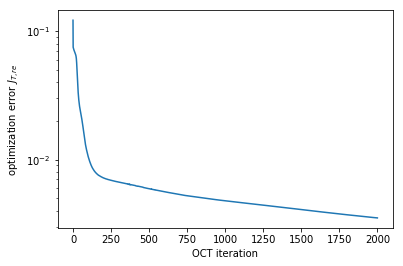

In [37]:
plot_convergence(oct_result)